In [43]:
import pandas as pd
import cv2
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from PIL import Image
import os
import pandas as pd
from torchvision import transforms
import torch.nn as nn

In [44]:
anot_path = "./data/attention.csv"
images_path = "./data/datasets/"

gray_images_path = "./data/grayimage"

In [45]:
df = pd.read_csv(anot_path)
df.columns = ['filename', 'score']
df['score'].value_counts()

score
4    113
2     55
1     55
3     47
0     29
Name: count, dtype: int64

In [46]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = int(self.labels_df.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

In [57]:
transform = transforms.Compose([
    transforms.Resize((512,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

In [58]:
dataset = CustomImageDataset(csv_file=anot_path, img_dir=images_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle=False)

In [59]:
model = models.efficientnet_b0(pretrained=True)
model.classifier = torch.nn.Identity()
model = model.to('cuda')
model.eval()

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [60]:
features = []
labels = []

with torch.no_grad():
    for images, label in train_loader:
        images = images.to('cuda')
        outputs = model(images)
        features.append(outputs.cpu().numpy())
        labels.extend(label.cpu().numpy())

X_feat = np.concatenate(features, axis=0)
y_feat = np.array(labels)

print("Shape of X_feat: ", X_feat.shape)
print("Shape of y_feat: ", y_feat.shape)

Shape of X_feat:  (299, 1280)
Shape of y_feat:  (299,)


In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_feat, y_feat, test_size=0.2, random_state=42, stratify=y_feat
)

In [68]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weights_dict = {i: w for i, w in enumerate(class_weights)}

### SVM

In [69]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

params = {
    'C' : [0.1, 1, 10],
    'gamma' : ['scale', 0.01, 0.001],
    'kernel' : ['rbf', 'linear'],
    'class_weight' : [weights_dict],
}

clf = GridSearchCV(SVC(), params, cv=5)
clf.fit(X_train, y_train)
train_acc = accuracy_score(y_train, y_train)
print(f"Train Acc : {train_acc*100:.2f}%")

Train Acc : 100.00%


In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(y_true, y_pred, class_names=None):
    """
    Evaluasi dan visualisasi hasil klasifikasi.

    Args:
        y_true (array): Label sebenarnya.
        y_pred (array): Label prediksi.
        class_names (list): Daftar nama kelas.
    """
    acc = accuracy_score(y_true, y_pred)
    print(f"🔍 Accuracy: {acc * 100:.2f}%\n")
    
    print("📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('🧩 Confusion Matrix')
    plt.show()


Test Accuracy : 28.33%
🔍 Accuracy: 28.33%

📊 Classification Report:
              precision    recall  f1-score   support

     class_0       0.33      0.17      0.22         6
     class_1       0.00      0.00      0.00        11
     class_2       0.00      0.00      0.00        11
     class_3       0.00      0.00      0.00         9
     class_4       0.41      0.70      0.52        23

    accuracy                           0.28        60
   macro avg       0.15      0.17      0.15        60
weighted avg       0.19      0.28      0.22        60



C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


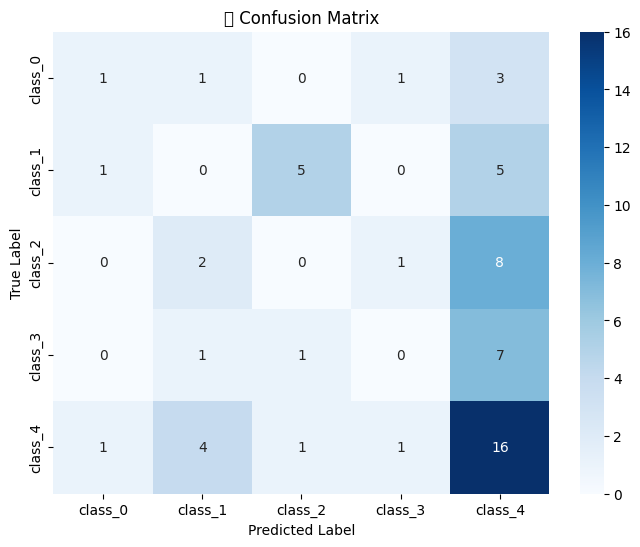

In [71]:
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy : {acc * 100:.2f}%")

class_names = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4']

evaluate_model(y_test, y_pred, class_names=class_names)

### Logistic Regression

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

logres = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight=weights_dict)
logres.fit(X_train, y_train)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 2.0782608695652174, 1: 1.0863636363636364,
                                 2: 1.0863636363636364, 3: 1.2578947368421052,
                                 4: 0.5311111111111111},
                   multi_class='multinomial')

In [75]:
y_pred = clf.predict(X_test)

print(f"Acc : {accuracy_score(y_test, y_pred)}")
print(f'Classfication Report: \n{classification_report(y_test, y_pred)}')

Acc : 0.2833333333333333
Classfication Report: 
              precision    recall  f1-score   support

           0       0.33      0.17      0.22         6
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00         9
           4       0.41      0.70      0.52        23

    accuracy                           0.28        60
   macro avg       0.15      0.17      0.15        60
weighted avg       0.19      0.28      0.22        60



### Random Forest / Gradient Boosting

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

clf = RandomForestClassifier(class_weight=weights_dict)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Accuracy: 0.3
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00         9
           4       0.37      0.78      0.50        23

    accuracy                           0.30        60
   macro avg       0.07      0.16      0.10        60
weighted avg       0.14      0.30      0.19        60



### Multi Layer Perceptron

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# MLP Architecture
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)  # First fully connected layer
        self.fc2 = nn.Linear(512, 256)       # Second fully connected layer
        self.fc3 = nn.Linear(256, output_dim)  # Output layer for multi-class classification
        self.dropout = nn.Dropout(0.5)        # Dropout to prevent overfitting

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output logits for each class
        return x

# Hyperparameters
input_dim = X_feat.shape[1]  # Fitur input dari hasil ekstraksi EfficientNet
output_dim = 5  # Jumlah kelas (ganti dengan jumlah kelas Anda)
batch_size = 32
learning_rate = 0.001
epochs = 20

# Convert data to tensor
X_feat_tensor = torch.tensor(X_train, dtype=torch.float32)
y_feat_tensor = torch.tensor(y_train, dtype=torch.long)

# Create DataLoader
dataset = TensorDataset(X_feat_tensor, y_feat_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate model
model = MLP(input_dim=input_dim, output_dim=output_dim).to('cuda')

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Loss function untuk multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [92]:
# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        optimizer.zero_grad()  # Zero out the gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate predictions
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_preds / total_preds

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/20, Loss: 1.5413, Accuracy: 0.3473
Epoch 2/20, Loss: 1.4343, Accuracy: 0.4142
Epoch 3/20, Loss: 1.3171, Accuracy: 0.4268
Epoch 4/20, Loss: 1.2401, Accuracy: 0.4937
Epoch 5/20, Loss: 1.0826, Accuracy: 0.5774
Epoch 6/20, Loss: 0.9165, Accuracy: 0.6527
Epoch 7/20, Loss: 0.7262, Accuracy: 0.7531
Epoch 8/20, Loss: 0.6157, Accuracy: 0.8243
Epoch 9/20, Loss: 0.5201, Accuracy: 0.8410
Epoch 10/20, Loss: 0.4458, Accuracy: 0.8452
Epoch 11/20, Loss: 0.3636, Accuracy: 0.8661
Epoch 12/20, Loss: 0.3108, Accuracy: 0.8912
Epoch 13/20, Loss: 0.2376, Accuracy: 0.9247
Epoch 14/20, Loss: 0.1668, Accuracy: 0.9498
Epoch 15/20, Loss: 0.1356, Accuracy: 0.9623
Epoch 16/20, Loss: 0.0928, Accuracy: 0.9791
Epoch 17/20, Loss: 0.0989, Accuracy: 0.9791
Epoch 18/20, Loss: 0.0833, Accuracy: 0.9791
Epoch 19/20, Loss: 0.0538, Accuracy: 0.9916
Epoch 20/20, Loss: 0.0500, Accuracy: 0.9833


In [ ]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [94]:
# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor.to('cuda'))
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test_tensor.cpu(), predicted.cpu())
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.2833
